<a href="https://colab.research.google.com/github/TanX-357/Word_Recognition_using_deep_CNN/blob/main/Word_Recognition_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolution Neural Networks
Link to the dataset : https://drive.google.com/file/d/14HjM98X9T2LIw7L5Io6kq0uRc9GFN93z/view?usp=sharing

---




# Title: Word Recognition

The objective is to train a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*Levels 2-5 wold be used in this project*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of 11 primitve shapes present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

* Level 1-5 would be used in this project. 

The objective of the project is to detemine which representation will be more helpful for word recognition. 



In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random
from google.colab.patches import cv2_imshow

In [ ]:
IMG_HEIGHT = 50
IMG_WIDTH = 250

from google.colab import drive
# I have unzipped the dataset folder myself and then uploaded it to my drive with no change in the names of any folder or files ,
# so i am not unzipping using colab
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [ ]:
#Add the paths for train, validation and test directories
train_dir_path="/content/gdrive/My Drive/WR-Dataset/Train/"
validation_dir_path="/content/gdrive/My Drive/WR-Dataset/Validation"
test_dir_path="/content/gdrive/My Drive/WR-Dataset/Test"

# Visualizing sample images

Prepare an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, Mention the number of word classes present in each of the three sets.

----

**(1+1+1) points**

---

In [ ]:
# Insert code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))
def get_dataframe(folder_name):
    list_of_images=[]
    Label_of_list_of_images=[]
    for file in os.listdir(folder_name):
        img_path=os.path.join(folder_name,file)
        label_name=""
        # I will be using the fact that the naming convention of the images file is of the form label_name+'_'+something 
        for i in file:
          if i!='_':
            label_name+=i
          else:
            break
        Label_of_list_of_images.append(label_name)
        # I am not storing the file path/file name in list_of_images this time,as it is more convenient for me to store the pixel 
        # representation of image(in RGB format)  
        list_of_images.append(cv2.imread(img_path))
    data = {'Image':list_of_images,
        'Label':Label_of_list_of_images}
  
    # Create DataFrame
    df = pd.DataFrame(data)
    #display and return the dataframe
    # displaying is done in the furthur section
    return df
df_train=get_dataframe(train_dir_path)
df_val=get_dataframe(validation_dir_path)
df_test=get_dataframe(test_dir_path)

# display the dataframes
print("FOR TRAIN DIRECTORY: ",df_train)
print("FOR VALIDATION DIRECTORY: ",df_val)
print("FOR TEST DIRECTORY: ",df_test)

# RESCALING OF RGB values by factor of 1/255 has been done furthur

#VISUALIZATION IN THE NEXT CELL


FOR TRAIN DIRECTORY:                                                    Image      Label
0     [[[255, 255, 255], [255, 255, 255], [255, 255,...         of
1     [[[255, 255, 255], [255, 255, 255], [255, 255,...     number
2     [[[255, 255, 255], [255, 255, 255], [255, 255,...         no
3     [[[255, 255, 255], [255, 255, 255], [255, 255,...        off
4     [[[255, 255, 255], [255, 255, 255], [255, 255,...        one
...                                                 ...        ...
2047  [[[255, 255, 255], [255, 255, 255], [255, 255,...        any
2048  [[[255, 255, 255], [255, 255, 255], [255, 255,...  available
2049  [[[255, 255, 255], [255, 255, 255], [255, 255,...        are
2050  [[[255, 255, 255], [255, 255, 255], [255, 255,...         at
2051  [[[255, 255, 255], [255, 255, 255], [255, 255,...         at

[2052 rows x 2 columns]
FOR VALIDATION DIRECTORY:                                                   Image     Label
0    [[[255, 255, 255], [255, 255, 255], [255, 255,...   

VISUALISING IMAGES FROM TRAIN SET


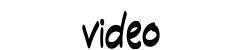

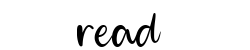

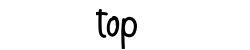

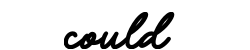

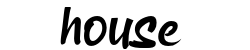

VISUALISING IMAGES FROM VALIDATION SET


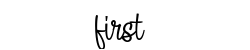

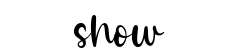

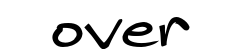

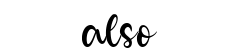

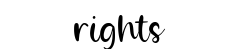

VISUALISING IMAGES FROM TEST SET


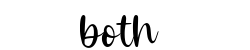

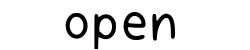

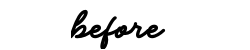

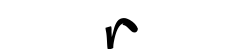

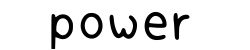

In [ ]:
# Visualise images from the train set
print("VISUALISING IMAGES FROM TRAIN SET")
x=pd.DataFrame(df_train,columns=['Image'])
list_of_train_img=(list(x['Image']))
randomly_chosen_label_list = random.choices(list_of_train_img, k=5) #random 5 images from train dataset
for i in range(5):
  cv2_imshow(randomly_chosen_label_list[i])


# Visualise images from the validation set
print("VISUALISING IMAGES FROM VALIDATION SET")
x=pd.DataFrame(df_val,columns=['Image'])
list_of_val_img=(list(x['Image']))
randomly_chosen_label_list = random.choices(list_of_val_img, k=5) #random 5 images from validation dataset
for i in range(5):
  cv2_imshow(randomly_chosen_label_list[i])



# Visualise images from the test set
print("VISUALISING IMAGES FROM TEST SET")
x=pd.DataFrame(df_test,columns=['Image'])
list_of_test_img=(list(x['Image']))
randomly_chosen_label_list = random.choices(list_of_test_img, k=5) #random 5 images from test dataset
for i in range(5):
  cv2_imshow(randomly_chosen_label_list[i])

Now, you will have to write modules that can give you vector representations for the input words.

---

**(3 + 3 points)**

---

In [ ]:
# I am creating an extra function to create a certain Level representation of image,eg Level 1 or Level 2 of any other Level x
import math

# The function seg_div(used to create segments for Level x representation) is a recursive function.
# Each time, we call the function it creates a one segment of word and then call itself again for creating next segment,this goes on unless
# the no of segments is equal to x(for Level x representation).
# The segments are created from the pseudo end of the word,pseudo end here means the end of the word which is available for creating segments. 

def seg_div(word,no_of_seg_left_to_create,length_left,seg_list):
  
  # arguments explaination

  # word is the original word whose Level representation is to be created
  # no_of_seg_left_to_create is actually the no of segments of the word left to create,like for any random level x representation,we need to create x segments
  # length_left is the length of the image left for creating segments,like each time when i call this function one segment of the word will be created,so that segment will no longer be contributing to any other segment,so that segment is avoided by using this argument.
  # seg_list is the list comprising of all segments of the word at Level x,there will be x segments in layer x representation.

  if length_left and no_of_seg_left_to_create:
    rem=length_left%no_of_seg_left_to_create
    x=math.floor(length_left/no_of_seg_left_to_create)
    if rem>0:
      rem=1 # since the extra letters while creating segments are givan to the segments more closer to the end of the word  
    seg_list.insert(0,word[length_left-(rem+x):length_left])
    length_left=length_left-(rem+x) # segment of length (rem+x) would result in decrease in length_left by (rem+x) where rem is 0 or 1.
  else:
    if no_of_seg_left_to_create!=0:
      seg_list.insert(0,"") #since no length_left but we need to create segments,thus empty string segments would be created
    else:
      return seg_list
  seg_div(word,no_of_seg_left_to_create-1,length_left,seg_list)# recursive calling for creating next_segment

  return seg_list





In [ ]:
from numpy import genfromtxt
# i am using this as i want this to be in np.array() format for leveraging the indexing/slicing benefits furthur
my_data = genfromtxt('/content/gdrive/My Drive/WR-Dataset/Alphabet.csv', delimiter=',')

def get_Omega_vector(word):

  #Insert the code for a function that returns Omega representation of the input word
  #Hint: For computing count of segments, you can add count of shapes for individual characters (already provided in Alphabet.csv file)
  vector_for_entire_word=np.array([])
  for i in range(1,6): # For Omega representation Layer 1 to Layer 5 need to be considered
    seg_list=[] # seg_list is the list comprising of all segments of the word at Level i,there will be i segments in layer i representation.
    seg_list=seg_div(word,i,len(word),seg_list) 
    ## print("seglist  ",seg_list)
    ## np.concatenate([all_seg_list,np.array(seg_list)])
    for words in seg_list:
      vector_for_every_gen_word=np.zeros(11) # each segment can be represented in terms of count of 11 primitve shapes present in various segments of image acc to omega repr.
      for letter in words:
        # since there is no header in Alphabet.csv, so i th row in the .csv file will correspond to ith alphabet representation(in lexiographical order)
        vector_for_every_gen_word+=my_data[ord(letter.lower())-97][1:] #the first(or zeroth index) column contains the alphabet in Alphabet.csv file so skipping that
      vector_for_entire_word=np.concatenate([vector_for_entire_word ,vector_for_every_gen_word])
  # print(vector)
  return (vector_for_entire_word) 

      


In [ ]:
#Insert the code for a function that returns Alpha representation of the input word 

def get_Alpha_vector(word):
  vector_for_entire_word=np.array([])
  for i in range(2,6): # For Alpha representation Layer 2 to Layer 5 need to be considered
    seg_list=[]
    seg_list=seg_div(word,i,len(word),seg_list)
    # print("seglisstt  ",seg_list)
    for words in seg_list:
      vector_for_every_gen_word=np.zeros(26) #each segment is represented in terms of 26 dimensions.
      for letter in words:
        # ith alphabet(in sequential order) will lead to incrementing ith index in the vector
        vector_for_every_gen_word[ord(letter.lower())-97]+=1; 
      vector_for_entire_word=np.concatenate([vector_for_entire_word,vector_for_every_gen_word])
  return vector_for_entire_word

    
    

To test the above modules, try printing Omega and Alpha vectors for your first name.

In [ ]:
name ="tanmay"

print("Omega vector:",get_Omega_vector(name))

print("Alpha vector:",get_Alpha_vector(name))


Omega vector: [0. 1. 2. 0. 0. 0. 2. 8. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 4. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 4. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 2. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 5. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
Alpha vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Alpha model.

---

**(3 points)**

---

In [ ]:
#Inserting the code for function that returns a model which will predict Alpharepresentation
def Alpha_model(learning_rate=1e-4):

    # Instantiate Sequential model

    model = tf.keras.models.Sequential()
    
    # Add Layers

    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))    
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_WIDTH,IMG_HEIGHT, 3),padding='same'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(364,activation='sigmoid'))

    # Define optimizers(Adam Optimizers), loss function and similarity metrics

    opt = tf.keras.optimizers.Adam(learning_rate)
    bce = tf.keras.losses.BinaryCrossentropy()
    metrics=[tf.keras.metrics.CosineSimilarity()]

    # Compile the model

    model.compile(optimizer=opt, loss=bce, metrics=metrics)

    # return model
    
    return model
    
    
   
    
    

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Omega model.

---

**(3 points)**

---

In [ ]:
#Insert the code for function that returns a model which will predict Omega representation

def Omega_model(learning_rate=1e-4):

    # Instantiate Sequential model

    model = tf.keras.models.Sequential()
    
    # Add Layers

    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))    
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(165,activation='relu'))

    # Define optimizers(Adam Optimizers), loss function and similarity metrics

    opt = tf.keras.optimizers.Adam(learning_rate)
    mse=tf.keras.losses.MeanSquaredError()
    metrics=[tf.keras.metrics.CosineSimilarity()]

    # Compile the model

    model.compile(optimizer=opt, loss=mse, metrics=metrics)

    # return model
    
    return model
    
    
    
    

Why did we use BCE as loss function and sigmoid as activation for final layer in Alpha model, while MSE and ReLu for Omega model? 

----

#### FOR ALPHA: sigmoid is used as activation for final layer it is like we are predicting that a particular alphabet will ocur at paricular position or not,so it is like probability,lying between 0 and 1 and for Omega model ReLu is used as it the output range is high comparitively and aslo ReLU converges also faster.
#### FOR Alpha: BCE is used as a loss function as we are modelling a probabilistic model,so BCE would give us the estimate of the difference between the actual probability distribution and the probability distribution of our model and omega has regression type output(continuous), so MSE is used for better estimate.
---





## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.

----

**1 point**

---

In [ ]:
#Insert code to print seen word classes 

print("SEEN WORDS: ")

seen_words=set(list(pd.DataFrame(df_train,columns=['Label'])['Label']))

print(seen_words)

#Insert code to print unseen word classes from test set

print("UNSEEN WORDS: ")

x=list(pd.DataFrame(df_test,columns=['Label'])['Label'])

llist=[]
for item in x:
  if item not in seen_words:
    llist.append(item)
    
unseen_words=(set(llist))

print(unseen_words)

SEEN WORDS: 
{'then', 'was', 'out', 'based', 'does', 'jan', 'under', 'message', 'did', 'university', 'community', 'details', 'system', 'games', 'map', 's', 'life', 'even', 'policy', 'this', 'g', 'local', 'website', 'how', 'or', 'state', 'hotels', 'related', 'view', 'am', 'f', 'many', 'report', 'service', 'day', 'off', 'your', 'states', 'development', 'free', 'company', 'most', 'reviews', 'black', 'who', 'books', 'dvd', 'education', 'forum', 'technology', 'site', 'c', 'check', 'way', 'copyright', 'd', 'said', 'its', 'each', 'just', 're', 'data', 'so', 'services', 'read', 'special', 'within', 'e', 'found', 'no', 'shipping', 'file', 'over', 'me', 'index', 'right', 'as', 'office', 'an', 'post', 'any', 'could', 'pages', 'de', 'privacy', 'much', 'subject', 'which', 't', 'internet', 'work', 'show', 'their', 'his', 'we', 'good', 'hotel', 'pm', 'posted', 'type', 'use', 'links', 'go', 'next', 'want', 'b', 'national', 'online', 'security', 'first', 'number', 'through', 'uk', 'where', 'high', 'tha

In [ ]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 

----

**1 point**

---

In [ ]:
#Insert the code for loading train and validation set images and their corresponding labels 

y_train=list(pd.DataFrame(df_train,columns=['Label'])['Label'])

omega_y_train=[]
for item in y_train:
  omega_y_train.append(get_Omega_vector(item))

y_val=list(pd.DataFrame(df_val,columns=['Label'])['Label'])

omega_y_val=[]
for item in y_val:
  omega_y_val.append(get_Omega_vector(item))

x_train=list(pd.DataFrame(df_train,columns=['Image'])['Image'])
x_val=list(pd.DataFrame(df_val,columns=['Image'])['Image'])

# rescaling the RGB value of pixel by 1./255

x_val=np.divide(x_val,255)
x_train=np.divide(x_train,255)

#reshaping x_train and x_val for compatibility with the model, in channel_last manner

X_train = np.array(x_train).reshape(len(x_train), 50, 250, 3)
X_val = np.array(x_val).reshape(len(x_val), 50, 250, 3)

#reshaping omega_y_train and omega_y_val for compatibility with the model, avoiding data cardinality compatibility issues

omega_Y_train=np.empty((0,165), int)

for i in omega_y_train:
  omega_Y_train=np.append(omega_Y_train,np.array([i]),axis=0)
  
omega_Y_val=np.empty((0,165), int)

for i in omega_y_val:
  omega_Y_val=np.append(omega_Y_val,np.array([i]),axis=0)

print("For Omega Model")
print("The shape of training dataset: ",X_train.shape)
print("The shape of output label dataset for training : ",omega_Y_train.shape)
print("The shape of validation dataset: ",X_val.shape)
print("The shape of output label dataset for validation: ",omega_Y_val.shape)

For Omega Model
The shape of training dataset:  (2052, 50, 250, 3)
The shape of output label dataset for training :  (2052, 165)
The shape of validation dataset:  (108, 50, 250, 3)
The shape of output label dataset for validation:  (108, 165)


Now find the best LR for the Omega model.

----

**4 points**

---

In [ ]:
def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:

      # Insert your code here to build a model with the current learning rate

      model=Omega_model(l_rate)
      
      # Insert your code here to train the model using the training set and validate using the validation set
      
      r=model.fit(X_train,omega_Y_train,validation_data=(X_val,omega_Y_val),epochs=NUM_EPOCHS,batch_size=BATCH_SIZE)

      # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list

      avg_val_similarity.append(np.mean(r.history['val_cosine_similarity']))
      
    
    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    return learning_rates[avg_val_similarity.index(max(avg_val_similarity))] #using the inbuilt functions to compute it
    


# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

print("The Best Learning Rate for Omega model: ",best_Omega_lr)

Epoch 1/30
257/257 [==============================] - 18s 68ms/step - loss: 0.4094 - cosine_similarity: 0.6594 - val_loss: 0.3000 - val_cosine_similarity: 0.7046
Epoch 2/30
257/257 [==============================] - 17s 67ms/step - loss: 0.3137 - cosine_similarity: 0.6814 - val_loss: 0.2984 - val_cosine_similarity: 0.7074
Epoch 3/30
257/257 [==============================] - 17s 68ms/step - loss: 0.3234 - cosine_similarity: 0.6860 - val_loss: 0.2970 - val_cosine_similarity: 0.7089
Epoch 4/30
257/257 [==============================] - 17s 68ms/step - loss: 0.3055 - cosine_similarity: 0.6931 - val_loss: 0.2957 - val_cosine_similarity: 0.7099
Epoch 5/30
257/257 [==============================] - 18s 68ms/step - loss: 0.3095 - cosine_similarity: 0.6889 - val_loss: 0.2946 - val_cosine_similarity: 0.7119
Epoch 6/30
257/257 [==============================] - 18s 69ms/step - loss: 0.3088 - cosine_similarity: 0.6921 - val_loss: 0.2941 - val_cosine_similarity: 0.7132
Epoch 7/30
257/257 [========

# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 

---

**1 Point**

---

In [ ]:
#Insert the code for loading train and validation set images and their corresponding labels (1 point)

# We do not need to make any changes for the X_val and X_train as it would remain same for alpha and omega model,only output label would vary.

y_train=list(pd.DataFrame(df_train,columns=['Label'])['Label'])

alpha_y_train=[]
for item in y_train:
  alpha_y_train.append(get_Alpha_vector(item))

y_val=list(pd.DataFrame(df_val,columns=['Label'])['Label'])

alpha_y_val=[]
for item in y_val:
  alpha_y_val.append(get_Alpha_vector(item))

#reshaping alpha_y_train and alpha_y_val for compatibility with the model, avoiding data cardinality compatibility issues

Alpha_Y_train=np.empty((0,364), int)

for i in alpha_y_train:
  Alpha_Y_train=np.append(Alpha_Y_train,np.array([i]),axis=0)
  
Alpha_Y_val=np.empty((0,364), int)

for i in alpha_y_val:
  Alpha_Y_val=np.append(Alpha_Y_val,np.array([i]),axis=0)

print("For Alpha Model")
print("The shape of training dataset: ",X_train.shape)
print("The shape of output label dataset for training : ",Alpha_Y_train.shape)
print("The shape of validation dataset: ",X_val.shape)
print("The shape of output label dataset for validation: ",Alpha_Y_val.shape)

For Alpha Model
The shape of training dataset:  (2052, 50, 250, 3)
The shape of output label dataset for training :  (2052, 364)
The shape of validation dataset:  (108, 50, 250, 3)
The shape of output label dataset for validation:  (108, 364)


Now find the best LR for the Omega model.

----

**4 points**

---

In [ ]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:

      # Insert your code here to build a model with the current learning rate
      
      model=Alpha_model(l_rate)
      
      # Insert your code here to train the model using the training set and validate using the validation set

      r=model.fit(X_train,Alpha_Y_train,validation_data=(X_val,Alpha_Y_val),epochs=NUM_EPOCHS,batch_size=BATCH_SIZE)
      
      # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list

      avg_val_similarity.append(np.mean(r.history['val_cosine_similarity']))
      
    
    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    return learning_rates[avg_val_similarity.index(max(avg_val_similarity))]
  
# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()
print("The Best Learning Rate for Alpha model: ",best_Alpha_lr)

Epoch 1/30
257/257 [==============================] - 18s 68ms/step - loss: 0.2227 - cosine_similarity: 0.2831 - val_loss: 0.1654 - val_cosine_similarity: 0.2977
Epoch 2/30
257/257 [==============================] - 17s 68ms/step - loss: 0.1735 - cosine_similarity: 0.3044 - val_loss: 0.1653 - val_cosine_similarity: 0.2970
Epoch 3/30
257/257 [==============================] - 17s 68ms/step - loss: 0.1731 - cosine_similarity: 0.3089 - val_loss: 0.1654 - val_cosine_similarity: 0.2930
Epoch 4/30
257/257 [==============================] - 18s 68ms/step - loss: 0.1741 - cosine_similarity: 0.3067 - val_loss: 0.1654 - val_cosine_similarity: 0.2944
Epoch 5/30
257/257 [==============================] - 18s 69ms/step - loss: 0.1706 - cosine_similarity: 0.3068 - val_loss: 0.1661 - val_cosine_similarity: 0.2906
Epoch 6/30
257/257 [==============================] - 18s 70ms/step - loss: 0.1713 - cosine_similarity: 0.3070 - val_loss: 0.1653 - val_cosine_similarity: 0.2966
Epoch 7/30
257/257 [========

---

Describe the purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping() **[2 Points]**
*<b>PURPOSE: </b>It stops training if the model is not improving (static) wrt a performance metrics<br>
*<b>ARGUMENTS: </b>
> *<b>Monitor:</b>Quantity on which monitoring is to be done
   <br> 
   <b>Min_delta:</b>This is a threshold value,below which if there is absolute change in the quantity being monitored,then it will be considered as no improvement<br>
<b>Patience:</b>After a certain number of epochs with no progress, training will be stopped.So this argument specifies that no of epochs with no improvement<br>
  <b>Mode:</b> {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.<br>
   <b>baseline:</b> Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline<br>
   <b>restore_best_weights: </b>Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
   <br>
   

2. ReduceLROnPlateau() **[2 Points]**
*<b>PURPOSE: </b>It reduces the learning the rate when it sees that metric has stopped improving<br>
*<b>ARGUMENTS: </b>
> *<b>Monitor:</b>Quantity on which monitoring is to be done
   <br> 
   <b>Factor:</b>factor by which the learning rate will be reduced. new_lr = lr * factor.<br>
<b>Patience:</b>After a certain number of epochs with no progress, training will be stopped.So this argument specifies that no of epochs with no improvement<br>
  <b>Mode:</b> {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.<br>
   <b>Min_delta:</b>This is a threshold value,below which if there is absolute change in the quantity being monitored,then it will be considered as no improvement<br>
   <b>cooldown: </b>number of epochs to wait before resuming normal operation after lr has been reduced.<br>
   <b>min_lr: </b>lower bound on the learning rate<br>
> *Your answer here*

3. CSVLogger() **[2 Points]**

*<b>PURPOSE: </b>Callback that streams epoch results to a CSV file.<br>
*<b>ARGUMENTS: </b>
> *<b>Filename:</b>Filename of the CSV file.
   <br> 
   <b>Separator:</b>String used to separate elements in the CSV file.<br>
<b>Append:</b>Boolean. True: append if file exists (useful for continuing training). False: overwrite existing file.<br>


4. ModelCheckPoint()  **[2 Points]**

*<b>PURPOSE: </b>Callback to save the Keras model or model weights at some frequency.<br>
*<b>ARGUMENTS: </b>
> *<b>filepath:</b>string or PathLike, path to save the model file
   <br> 
   <b>Monitor:</b>Quantity(Metric) on which monitoring is to be done
   <br> 
   <b>Save_best_only:</b>if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten<br>
  <b>Mode:</b> {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.<br>
<b>save_weights_only:</b>if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).<br>
<b>save_freq:</b> 'epoch' or integer. When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches. If the Model is compiled with steps_per_execution=N, then the saving criteria will be checked every Nth batch.<br>
   <b>options: </b>Optional tf.train.CheckpointOptions object if save_weights_only is true or optional tf.saved_model.SaveOptions object if save_weights_only is false.
   <br>



# Model building and training using callbacks

---
Now build and summarize the Omega model as per the best learning rate value determined earlier.

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR determined
best_omega_model=Omega_model(best_Omega_lr)


Now instantiate the four callbacks which you have described above.


---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
model_earlystopping=tf.keras.callbacks.EarlyStopping(patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
model_reducelronplateau=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)


# CSVlogger for keeping logs in filename of your choice
model_csvlogger=tf.keras.callbacks.CSVLogger("2018eeb1187_Tanmay_training_omega.log")

# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_modelcheckpoint=tf.keras.callbacks.ModelCheckpoint(filepath="/content/gdrive/My Drive/WR-Dataset",save_freq=10)

# Make a list of all the callbacks
callback_list=[model_earlystopping, model_reducelronplateau, model_csvlogger, model_modelcheckpoint]



Now train the model using these callbacks for the loaded training word images.

---

**7 Points**

---

Epoch 1/30
257/257 [==============================] - 201s 782ms/step - loss: 0.3379 - cosine_similarity: 0.6548 - val_loss: 0.2328 - val_cosine_similarity: 0.7265
Epoch 2/30
257/257 [==============================] - 222s 866ms/step - loss: 0.2582 - cosine_similarity: 0.7050 - val_loss: 0.2175 - val_cosine_similarity: 0.7299
Epoch 3/30
257/257 [==============================] - 229s 896ms/step - loss: 0.2545 - cosine_similarity: 0.7043 - val_loss: 0.2193 - val_cosine_similarity: 0.7326
Epoch 4/30
257/257 [==============================] - 219s 854ms/step - loss: 0.2429 - cosine_similarity: 0.7105 - val_loss: 0.2132 - val_cosine_similarity: 0.7326
Epoch 5/30
257/257 [==============================] - 231s 902ms/step - loss: 0.2475 - cosine_similarity: 0.7162 - val_loss: 0.2463 - val_cosine_similarity: 0.7387
Epoch 6/30
257/257 [==============================] - 224s 875ms/step - loss: 0.2369 - cosine_similarity: 0.7181 - val_loss: 0.2131 - val_cosine_similarity: 0.7400
Epoch 7/30
257/2

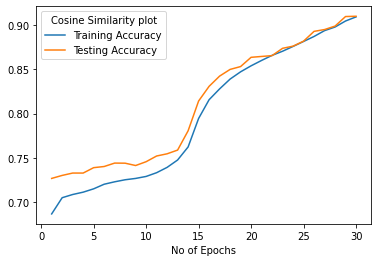

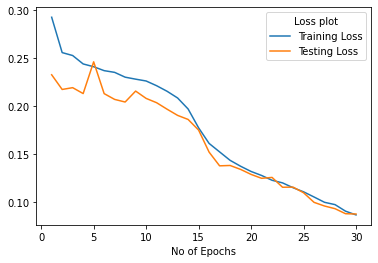

In [ ]:
# Insert code to train with callbacks (2 points)

r=best_omega_model.fit(X_train,omega_Y_train,validation_data=(X_val,omega_Y_val),epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,callbacks=callback_list)
best_omega_model.save("/content/gdrive/MyDrive/WR-Dataset/omega_model")

# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)

epochs=[]

training_accuracy=r.history['cosine_similarity']
validation_accuracy=r.history['val_cosine_similarity']

for i in range(1,len(training_accuracy)+1): # though we know that len(training_accuracy)=NUM_EPOCHS
  epochs.append(i)

training_loss=r.history['loss']
validation_loss=r.history['val_loss']

# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)

cosine_similarity_plot = plt.figure(1)
plt.plot(epochs,training_accuracy, label="Training Accuracy")
plt.plot(epochs,validation_accuracy, label="Testing Accuracy")
plt.xlabel("No of Epochs")
plt.legend(title="Cosine Similarity plot")



# Insert your code here to plot Epochs Vs. training and validation loss (2 Points)


loss_plot = plt.figure(2)
plt.plot(epochs,training_loss, label="Training Loss")
plt.plot(epochs,validation_loss, label="Testing Loss")
plt.xlabel("No of Epochs")
plt.legend(title="Loss plot")



plt.show() 







Now build and summarize the Alpha model as per the best learning rate value determined earlier. 

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR for Alpha model determined
best_alpha_model=Alpha_model(best_Alpha_lr)


Now instantiate the four callbacks for Alpha model.

---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
model_earlystopping=tf.keras.callbacks.EarlyStopping(patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
model_reducelronplateau=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)


# CSVlogger for keeping logs in filename of your choice
model_csvlogger=tf.keras.callbacks.CSVLogger("2018eeb1187_Tanmay_training_alpha.log")

# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_modelcheckpoint=tf.keras.callbacks.ModelCheckpoint(filepath="/content/gdrive/My Drive/WR-Dataset",save_freq=10)

# Make a list of all the callbacks
callback_list=[model_earlystopping, model_reducelronplateau, model_csvlogger, model_modelcheckpoint]




Now train the model with training data using these callbacks.

---

**7 Points**

---

Epoch 1/30
257/257 [==============================] - 234s 792ms/step - loss: 0.2938 - cosine_similarity: 0.2390 - val_loss: 0.1612 - val_cosine_similarity: 0.2970
Epoch 2/30
257/257 [==============================] - 231s 903ms/step - loss: 0.1695 - cosine_similarity: 0.2898 - val_loss: 0.1597 - val_cosine_similarity: 0.2962
Epoch 3/30
257/257 [==============================] - 235s 917ms/step - loss: 0.1682 - cosine_similarity: 0.2998 - val_loss: 0.1599 - val_cosine_similarity: 0.2979
Epoch 4/30
257/257 [==============================] - 230s 900ms/step - loss: 0.1684 - cosine_similarity: 0.3030 - val_loss: 0.1616 - val_cosine_similarity: 0.2963
Epoch 5/30
257/257 [==============================] - 235s 917ms/step - loss: 0.1651 - cosine_similarity: 0.3007 - val_loss: 0.1596 - val_cosine_similarity: 0.2933
Epoch 6/30
257/257 [==============================] - 234s 914ms/step - loss: 0.1688 - cosine_similarity: 0.3108 - val_loss: 0.1589 - val_cosine_similarity: 0.2971
Epoch 7/30
257/2

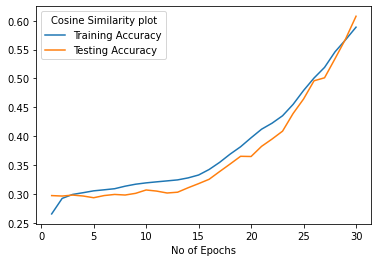

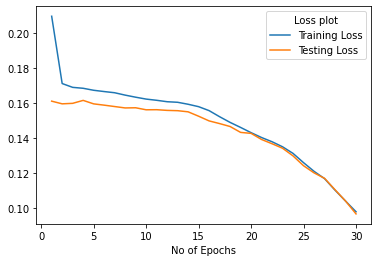

In [ ]:
# Insert code to train with callbacks (2 points)
r=best_alpha_model.fit(X_train,Alpha_Y_train,validation_data=(X_val,Alpha_Y_val),epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,callbacks=callback_list)
best_alpha_model.save("/content/gdrive/MyDrive/WR-Dataset/alpha_model")
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)

epochs=[]

training_accuracy=r.history['cosine_similarity']
validation_accuracy=r.history['val_cosine_similarity']

for i in range(1,len(training_accuracy)+1):
  epochs.append(i)

training_loss=r.history['loss']
validation_loss=r.history['val_loss']

# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)

plot1 = plt.figure(1)
plt.plot(epochs,training_accuracy, label="Training Accuracy")
plt.plot(epochs,validation_accuracy, label="Testing Accuracy")
plt.xlabel("No of Epochs")
plt.legend(title="Cosine Similarity plot")



# Insert your code here to plot Epochs Vs. training and validation loss (2 Points)

plot2 = plt.figure(2)
plt.plot(epochs,training_loss, label="Training Loss")
plt.plot(epochs,validation_loss, label="Testing Loss")
plt.xlabel("No of Epochs")
plt.legend(title="Loss plot")




plt.show()







## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).

---

**1 point**

---


In [ ]:

y_test=list(pd.DataFrame(df_test,columns=['Label'])['Label'])
x_test=list(pd.DataFrame(df_test,columns=['Image'])['Image'])

omega_y_test=[]
alpha_y_test=[]

for item in y_test:
  omega_y_test.append(get_Omega_vector(item))
  alpha_y_test.append(get_Alpha_vector(item))


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.

---

**1 point**

---

In [ ]:
# Insert code to load test images and its vector labels (1 points)

# rescaling by a factor of 1./255

x_test=np.divide(x_test,255)
X_test = np.array(x_test).reshape(len(x_test), 50, 250, 3)

Alpha_y_test=np.empty((0,364), int)

for i in alpha_y_test:
  Alpha_y_test=np.append(Alpha_y_test,np.array([i]),axis=0) 



Now load the saved trained Alpha model from the file and predict the labels

---

**1+3 points**

---

In [ ]:
# Insert code for loading the saved model from file 
best_alpha_model = tf.keras.models.load_model("/content/gdrive/MyDrive/WR-Dataset/alpha_model")

In [ ]:
# Insert code for predicting word labels of the test set images 
# alpha_y_pred=best_alpha_model.predict(X_test)
# print("The shape of predicted label: ",alpha_y_pred.shape)
# word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
# Insert code for predicting word labels of the test set images 
# predict_omega_vector=model.predict(x_test, batch_size=BATCH_SIZE)
alpha_y_pred=best_alpha_model.predict(X_test, batch_size=BATCH_SIZE)
alpha_y_pred_label=[]
from scipy.spatial import distance
# predicted_omega_class=[]
alpha_y_class_pred=[]
Alpha_prediction=[]# it is 0 or 1 depending on whether the label is correctly predicted(1) or not(0)
for i in range(len(alpha_y_pred)):  
  label=i
  max_sim=(1 - distance.cosine(alpha_y_pred[i], Alpha_y_test[i]))
  for j in range(len(Alpha_y_test)): 
    sim=(1 - distance.cosine(alpha_y_pred[i], Alpha_y_test[j]))
    if sim > max_sim:
      max_sim=sim
      label=j
  alpha_y_pred_label.append(y_test[label])
  if label==i:
    Alpha_prediction.append(1)
  else:
    Alpha_prediction.append(0)
  
print(len(alpha_y_pred)) #Total_no_of_predictions
print(np.sum(Alpha_prediction)) #Total_correct_predictions

400
102


Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.

---

**2 Points**

---

In [ ]:
Y_test_unseen=np.empty((0,364), int)
x_test_unseen=[]
Y_test_seen=np.empty((0,364), int)
x_test_seen=[]
for item in range(len(y_test)):
  if y_test[item] in seen_words:
    Y_test_seen=np.append(Y_test_seen,np.array([get_Alpha_vector(y_test[item])]),axis=0)
    x_test_seen.append(x_test[item])
    # X_test_seen=np.append(X_test_seen,np.array([X_test[item]]),axis=0)
  else:
    Y_test_unseen=np.append(Y_test_unseen,np.array([get_Alpha_vector(y_test[item])]),axis=0)
    x_test_unseen.append(x_test[item])
    # X_test_unseen=np.append(X_test_unseen,np.array([X_test[item]]),axis=0)
X_test_seen = np.array(x_test_seen).reshape(len(x_test_seen), 50, 250, 3)
X_test_unseen = np.array(x_test_unseen).reshape(len(x_test_unseen), 50, 250, 3)


print("For ALPHA MODEL: ")

# Insert code to compute accuracy of images that belong to seen classes

alpha_score_seen_img = best_alpha_model.evaluate(X_test_seen, Y_test_seen, verbose = 0) 

print('Test accuracy for seen classes:', alpha_score_seen_img[1])



# Insert code to compute accuracy of images that belong to unseen classes

alpha_score_unseen_img = best_alpha_model.evaluate(X_test_unseen, Y_test_unseen, verbose = 0) 
print('Test accuracy for unseen classes:', alpha_score_unseen_img[1])

# Insert code to compute effective accuracy

print("Effective Accuracy: ",(2*alpha_score_seen_img[1]*alpha_score_unseen_img[1])/(alpha_score_seen_img[1]+alpha_score_unseen_img[1]))




For ALPHA MODEL: 
Test accuracy for seen classes: 0.6151129007339478
Test accuracy for unseen classes: 0.4589441418647766
Effective Accuracy:  0.5256749896527897


Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.

---

**1 Points**

---

In [ ]:
# Insert code to load test images and its vector labels
Omega_Y_test=np.empty((0,165), int)
for i in omega_y_test:
  Omega_Y_test=np.append(Omega_Y_test,np.array([i]),axis=0) 

Now load the saved trained Omega model from the file and predict the labels

---

**1+3 Points**

---

In [ ]:
# Insert code for loading the saved model from file
best_omega_model = tf.keras.models.load_model("/content/gdrive/MyDrive/WR-Dataset/omega_model")


In [ ]:
# Insert code for predicting word labels of the test set images
# Insert code for predicting word labels of the test set images 
# alpha_y_pred=best_alpha_model.predict(X_test)
# print("The shape of predicted label: ",alpha_y_pred.shape)
# word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
# Insert code for predicting word labels of the test set images 
# predict_omega_vector=model.predict(x_test, batch_size=BATCH_SIZE)
omega_y_pred=best_omega_model.predict(X_test, batch_size=BATCH_SIZE)
omege_y_pred_label=[]

from scipy.spatial import distance
omega_y_class_pred=[]
Omega_prediction=[] # it is 0 or 1 depending on whether the label is correctly predicted(1) or not(0)
for i in range(len(omega_y_pred)):  
  label=i
  max_sim=(1 - distance.cosine(omega_y_pred[i], Omega_Y_test[i]))
  for j in range(len(Omega_Y_test)): 
    sim=(1 - distance.cosine(omega_y_pred[i], Omega_Y_test[j]))
    # print(curr_cossim)
    if sim > max_sim:
      max_sim=sim
      label=j
  omega_y_pred_label.append(y_test[label])
  if label==i:
    Omega_prediction.append(1)
  else:
    Omega_prediction.append(0)
  
# print(word_label)
# print(omega_y_class_pred)
print(len(omega_y_pred)) #Total_no_of_predictions
print(np.sum(Omega_prediction)) #Total_corrrect_predictions


400
203


Evaluate the performance of the Omega model

---

**2 Points**

---

In [ ]:
# X_test_unseen and X_test_seen would remain same for both representations,alpha and omega. 

Y_test_unseen=np.empty((0,165), int)
Y_test_seen=np.empty((0,165), int)

for item in range(len(y_test)):
  if y_test[item] in seen_words:
    Y_test_seen=np.append(Y_test_seen,np.array([get_Omega_vector(y_test[item])]),axis=0)
  else:
    Y_test_unseen=np.append(Y_test_unseen,np.array([get_Omega_vector(y_test[item])]),axis=0)



print("For OMEGA MODEL: ")

# Insert code to compute accuracy of images that belong to seen classes

omega_score_seen_img = best_omega_model.evaluate(X_test_seen, Y_test_seen, verbose = 0) 

print('Test accuracy for seen classes:', omega_score_seen_img[1])



# Insert code to compute accuracy of images that belong to unseen classes

omega_score_unseen_img = best_omega_model.evaluate(X_test_unseen, Y_test_unseen, verbose = 0) 
print('Test accuracy for unseen classes:', omega_score_unseen_img[1])

# Insert code to compute effective accuracy

print("Effective Accuracy: ",(2*omega_score_seen_img[1]*omega_score_unseen_img[1])/(omega_score_seen_img[1]+omega_score_unseen_img[1]))


For OMEGA MODEL: 
Test accuracy for seen classes: 0.9158193469047546
Test accuracy for unseen classes: 0.8677610158920288
Effective Accuracy:  0.8911427187923034


# Results
Based on your experimental outcome and your observations, which representation is better, according to you? 

---

**Undoubtabely Omega representation turns out to be much better than the alpha representation.The omega model has very good accuracy value for both seen and unseen images over 90 and 85 percent respectively.Even while training,the validation accuracy was much better for Omega than Alpha representation.Also intuitively omega models looks to learn pattern in the shape of the words,rather than just focusing on the character occurance(like in the case of alpha representation)**

---

We have used only words from the test set to find the matching word. How could results be affected if the lexicon had both: train and test words?

---

**2 Points**

---

I think that for omega model,the results would not have been much different but alpha model accuracy must have been affected significantly,it would reduce furthur.As alpha model is more dependent on positioning and occurance of the characters,so words can have much more similarity comparitively,despite not being the correct label.So introduction of more words for similarity computation will lead to more inaccuracy whereas for omega this is not the case,it is focuses on learning representation in terms of shapes.